# Условный оператор `if` в форме оракула.

Для первой задачи вы напишете код для реализации

```
if (|x> < 0) {
    |y> = NOT|y>;
}
```

В форме двоичного оракула.

Оракулом называют функцию от 2 регистров: $|x\rangle$ аргумента и $|y\rangle$ результата. Поскольку на квантовые функции накладыается много ограничений, то придумали делать вот так:


![](https://qiskit.org/textbook/ch-algorithms/images/grover_boolean_oracle.svg)

Предполагается, что входное значение $|x\rangle$ не меняется, а выходное -- это `xor` от изначального значения $|y\rangle$ и результата вычисления функции $f(x)$. Поэтому очень удобно делать отмену вычислений: примените оракул ещё раз, и вы получите исходное состояние для всех регистров:

$$
Oracle|x\rangle|y\rangle = |x\rangle|y\oplus f(x)\rangle
\\
Oracle|x\rangle|y\oplus f(x)\rangle = |x\rangle|y\oplus f(x)\oplus f(x)\rangle\rangle=|x\rangle|y\rangle
$$


В нашей задаче строчка $|y\rangle = NOT|y\rangle$ как раз и вычисляет $|y\oplus f(x)\rangle$. Если $f(x)=1$, то значение $|y\rangle$ меняется на противоположное. То есть, то что мы с вами будет реализовывать и есть хороший оракул!

Как же нам реализовать условие? Очень просто, если мы вспомним про то, как работает дополнение до 2! В нём старший (ку)бит является индикатором знака. Если он равен 1, тогда число -- отрицательно. Напишите код, который применяет отрицание к регистру $|y\rangle$ если старший кубит нашего числа равен 1.

In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit import execute, BasicAer
import matplotlib.pyplot as plt

In [2]:
x = QuantumRegister(4, 'x')
y = QuantumRegister(1, 'y')
cr = ClassicalRegister(5, 'c')
qc = QuantumCircuit(x, y, cr)

In [3]:
# инициализируем x в 0101 = 5
# попробуйте самостоятельно заменить x = -5. Какая будет двоичная запись? Какой будет результат измерений

qc.x([x[0], x[2]])
# или 
# qc.initialize([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], x)

# ничего, или
qc.initialize([1, 0], y)
qc.barrier()

# напишите здесь код, выполняет if (x[3] == 1) {y = NOT y}.
qc.cnot(x[-1], y[0])

qc.barrier()
qc.measure(x[:] + y[:], cr)
qc.draw()

┌───┐        ░       ░ ┌─┐            
x_0: ───────┤ X ├────────░───────░─┤M├────────────
            └───┘        ░       ░ └╥┘┌─┐         
x_1: ────────────────────░───────░──╫─┤M├─────────
            ┌───┐        ░       ░  ║ └╥┘┌─┐      
x_2: ───────┤ X ├────────░───────░──╫──╫─┤M├──────
            └───┘        ░       ░  ║  ║ └╥┘┌─┐   
x_3: ────────────────────░───■───░──╫──╫──╫─┤M├───
     ┌─────────────────┐ ░ ┌─┴─┐ ░  ║  ║  ║ └╥┘┌─┐
y_0: ┤ Initialize(1,0) ├─░─┤ X ├─░──╫──╫──╫──╫─┤M├
     └─────────────────┘ ░ └───┘ ░  ║  ║  ║  ║ └╥┘
c: 5/═══════════════════════════════╩══╩══╩══╩══╩═
                                    0  1  2  3  4

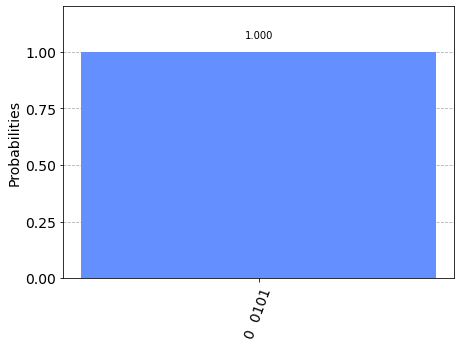

In [4]:
job = execute(qc, BasicAer.get_backend('qasm_simulator'), shots=10000)
counts = job.result().get_counts(qc)

counts_sep = {}
for key in counts:
    counts_sep[f"{key[0]}  {key[1:]}"] = counts[key]
plot_histogram(counts_sep)

## Усложним задачу  

```
if (|x> >= 3) {
    |y> = NOT|y>;
}
```

Что изменилось?
- поменялся знак сравнения.
- поменялась константа.

Как быть со знаком?

In [5]:
qc = QuantumCircuit(2)

# если 0 - будет 1
qc.x(0)

# контролируем
qc.cx(0, 1)

# отменяем вычисления!
qc.x(0)

qc.draw()

┌───┐     ┌───┐
q_0: ┤ X ├──■──┤ X ├
     └───┘┌─┴─┐└───┘
q_1: ─────┤ X ├─────
          └───┘

а как быть с константой? Очень просто!

$x \ge 3$ это то же самое, что и $x - 3 \ge 0$.

- `a -= 3`.
- контролирующие действия.
- `a += 3` - отмена вычислений (вернём регистр в исходное состояние).

## Давайте соберём всё вместе

- Вычтем 3 из $|x\rangle$
- Отрицание $|x\rangle$[3]
- контролируемое отрицание `if (|x>[3] == 1) { |y> = X|y> }`
- Отрицание $|x\rangle$[3] (отмена вычислений)
- Прибавим 3 к $|x\rangle$ (отмена вычислений)

А теперь напишите этот код :)

In [6]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit import execute, BasicAer

In [7]:
x = QuantumRegister(4, 'x')
y = QuantumRegister(1, 'y')
cr = ClassicalRegister(5, 'c')
qc = QuantumCircuit(x, y, cr)

### `x-=3`

In [8]:
# -= 2
qc.x(x[1])
qc.cx(x[1], x[2])
qc.ccx(x[1], x[2], x[3])
qc.barrier()
# -= 1
qc.x(x[0])
qc.cx(x[0], x[1])
qc.ccx(x[0], x[1], x[2])
qc.mct(x[:3], x[3])

qc.barrier()
qc.draw()

░ ┌───┐                ░ 
x_0: ────────────────░─┤ X ├──■────■────■───░─
     ┌───┐           ░ └───┘┌─┴─┐  │    │   ░ 
x_1: ┤ X ├──■────■───░──────┤ X ├──■────■───░─
     └───┘┌─┴─┐  │   ░      └───┘┌─┴─┐  │   ░ 
x_2: ─────┤ X ├──■───░───────────┤ X ├──■───░─
          └───┘┌─┴─┐ ░           └───┘┌─┴─┐ ░ 
x_3: ──────────┤ X ├─░────────────────┤ X ├─░─
               └───┘ ░                └───┘ ░ 
y_0: ────────────────░──────────────────────░─
                     ░                      ░ 
c: 5/═════════════════════════════════════════

### `if (x[3] == 0) y = ~y`

In [9]:
qc.x(x[3])
qc.cx(x[3], y[0])
qc.x(x[3])
qc.barrier()
qc.draw()

░ ┌───┐                ░                 ░ 
x_0: ────────────────░─┤ X ├──■────■────■───░─────────────────░─
     ┌───┐           ░ └───┘┌─┴─┐  │    │   ░                 ░ 
x_1: ┤ X ├──■────■───░──────┤ X ├──■────■───░─────────────────░─
     └───┘┌─┴─┐  │   ░      └───┘┌─┴─┐  │   ░                 ░ 
x_2: ─────┤ X ├──■───░───────────┤ X ├──■───░─────────────────░─
          └───┘┌─┴─┐ ░           └───┘┌─┴─┐ ░ ┌───┐     ┌───┐ ░ 
x_3: ──────────┤ X ├─░────────────────┤ X ├─░─┤ X ├──■──┤ X ├─░─
               └───┘ ░                └───┘ ░ └───┘┌─┴─┐└───┘ ░ 
y_0: ────────────────░──────────────────────░──────┤ X ├──────░─
                     ░                      ░      └───┘      ░ 
c: 5/═══════════════════════════════════════════════════════════

### Отмена вычислений `x += 3`

In [10]:
# x += 1

qc.mct(x[:3], x[3])
qc.ccx(x[0], x[1], x[2])
qc.cx(x[0], x[1])
qc.x(x[0])
qc.barrier()

# x += 2

qc.ccx(x[1], x[2], x[3])
qc.cx(x[1], x[2])
qc.x(x[1])

qc.barrier()


qc.barrier()
qc.draw()

░ ┌───┐                ░                 ░                »
x_0: ────────────────░─┤ X ├──■────■────■───░─────────────────░───■────■────■──»
     ┌───┐           ░ └───┘┌─┴─┐  │    │   ░                 ░   │    │  ┌─┴─┐»
x_1: ┤ X ├──■────■───░──────┤ X ├──■────■───░─────────────────░───■────■──┤ X ├»
     └───┘┌─┴─┐  │   ░      └───┘┌─┴─┐  │   ░                 ░   │  ┌─┴─┐└───┘»
x_2: ─────┤ X ├──■───░───────────┤ X ├──■───░─────────────────░───■──┤ X ├─────»
          └───┘┌─┴─┐ ░           └───┘┌─┴─┐ ░ ┌───┐     ┌───┐ ░ ┌─┴─┐└───┘     »
x_3: ──────────┤ X ├─░────────────────┤ X ├─░─┤ X ├──■──┤ X ├─░─┤ X ├──────────»
               └───┘ ░                └───┘ ░ └───┘┌─┴─┐└───┘ ░ └───┘          »
y_0: ────────────────░──────────────────────░──────┤ X ├──────░────────────────»
                     ░                      ░      └───┘      ░                »
c: 5/══════════════════════════════════════════════════════════════════════════»
                                                                               »
«     ┌───┐ ░                 ░  ░ 
«x_0: ┤ X ├─░─────────────────░──░─
«     └───┘ ░           ┌───┐ ░  ░ 
«x_1: ──────░───■────■──┤ X ├─░──░─
«           ░   │  ┌─┴─┐└───┘ ░  ░ 
«x_2: ──────░───■──┤ X ├──────░──░─
«           ░ ┌─┴─┐└───┘      ░  ░ 
«x_3: ──────░─┤ X ├───────────░──░─
«           ░ └───┘           ░  ░ 
«y_0: ──────░─────────────────░──░─
«           ░                 ░  ░ 
«c: 5/═════════════════════════════
«

## Всё вместе!

Наконец мы собрали функцию-оракула. В qiskit контур можно вернуть из функции и затем использовать как составной многокубитный вентиль. Закончите функцию `oracle()`, собрав в неё все действия, кроме инициализации регистров.

In [11]:
def oracle():
    x = QuantumRegister(4, 'x')
    y = QuantumRegister(1, 'y')
    qc = QuantumCircuit(x, y, name="oracle")
    
    #######

    qc.x(x[1])
    qc.cx(x[1], x[2])
    qc.ccx(x[1], x[2], x[3])
    qc.barrier()
    qc.x(x[0])
    qc.cx(x[0], x[1])
    qc.ccx(x[0], x[1], x[2])
    qc.mct(x[:3], x[3])

    qc.x(x[3])
    qc.cx(x[3], y[0])
    qc.x(x[3])
    
    qc.mct(x[:3], x[3])
    qc.ccx(x[0], x[1], x[2])
    qc.cx(x[0], x[1])
    qc.x(x[0])
    qc.ccx(x[1], x[2], x[3])
    qc.cx(x[1], x[2])
    qc.x(x[1])
    
    ########
    
    return qc

Протестируем нашу функцию. Она должна "возвращать" для чисел больше либо равных 3 единицу, для других 0.

In [12]:
xr = QuantumRegister(4, "x")
yr = QuantumRegister(1, "y")
cr = ClassicalRegister(5, "c")
test_circuit = QuantumCircuit(xr, yr, cr)

## здесь можно "поиграться" с входными данными. Мы приготовили для вас числo 7
test_circuit.initialize([0, 0, 0 ,0, 0, 0, 0, 1, 0, 0, 0 ,0, 0, 0, 0, 0], xr)

O = oracle()
test_circuit.append(O, xr[:] + yr[:])
test_circuit.measure(xr[:] + yr[:], cr)
test_circuit.draw()

┌──────────────────────────────────────────────┐┌─────────┐┌─┐            
x_0: ┤0                                             ├┤0        ├┤M├────────────
     │                                              ││         │└╥┘┌─┐         
x_1: ┤1                                             ├┤1        ├─╫─┤M├─────────
     │  Initialize(0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0) ││         │ ║ └╥┘┌─┐      
x_2: ┤2                                             ├┤2 oracle ├─╫──╫─┤M├──────
     │                                              ││         │ ║  ║ └╥┘┌─┐   
x_3: ┤3                                             ├┤3        ├─╫──╫──╫─┤M├───
     └──────────────────────────────────────────────┘│         │ ║  ║  ║ └╥┘┌─┐
y_0: ────────────────────────────────────────────────┤4        ├─╫──╫──╫──╫─┤M├
                                                     └─────────┘ ║  ║  ║  ║ └╥┘
c: 5/════════════════════════════════════════════════════════════╩══╩══╩══╩══╩═
                                                                 0  1  2  3  4

In [13]:
job = execute(test_circuit, BasicAer.get_backend('qasm_simulator'), shots=1000)
counts = job.result().get_counts(test_circuit)
key = list(counts.keys())[0]
print(f'x = {int(key[1:], base=2)}, Oracle = {key[0]}')

x = 7, Oracle = 1


Или даже так!

In [14]:
for i in range(8):
    x = [0] * 16
    x[i] = 1
    xr = QuantumRegister(4, "x")
    yr = QuantumRegister(1, "y")
    cr = ClassicalRegister(5, "c")
    test_circuit = QuantumCircuit(xr, yr, cr)
    test_circuit.initialize(x, xr)
    test_circuit.append(oracle(), xr[:] + yr[:])
    test_circuit.measure(xr[:] + yr[:], cr)
    counts = execute(
        test_circuit, 
        BasicAer.get_backend('qasm_simulator'), shots=1).result().get_counts(test_circuit)
    key = list(counts.keys())[0]
    print(f'x = {int(key[1:], base=2)}, Oracle = {key[0]}')

x = 0, Oracle = 0
x = 1, Oracle = 0
x = 2, Oracle = 0
x = 3, Oracle = 1
x = 4, Oracle = 1
x = 5, Oracle = 1
x = 6, Oracle = 1
x = 7, Oracle = 1


# Задание.
Подумайте, как выполнить функцию оракула для всех этих чисел одновременно? Как получить результат за один эксперимент?

In [15]:
xr = QuantumRegister(4, "x")
yr = QuantumRegister(1, "y")
cr = ClassicalRegister(5, "c")
test_circuit = QuantumCircuit(xr, yr, cr)
test_circuit.h(xr[:3])
test_circuit.append(oracle(), xr[:] + yr[:])
test_circuit.measure(xr[:] + yr[:], cr)
counts = execute(
    test_circuit, 
    BasicAer.get_backend('qasm_simulator'), shots=100).result().get_counts(test_circuit)
keys = list(counts.keys())
for key in sorted(keys):
    print(f'x = {int(key[1:], base=2)}, Oracle = {key[0]}')

x = 0, Oracle = 0
x = 1, Oracle = 0
x = 2, Oracle = 0
x = 3, Oracle = 1
x = 4, Oracle = 1
x = 5, Oracle = 1
x = 6, Oracle = 1
x = 7, Oracle = 1
